# Exercise 5 - Thyroid desease prediction using Convolutional Neural Networks


Available at: 
- https://archive.ics.uci.edu/ml/datasets/Thyroid+Disease
- http://networkrepository.com/thyroid-disease-thyroid0387.php
- https://search.r-project.org/CRAN/refmans/MoTBFs/html/thyroid.html

## 1. Importing libraries

In [149]:
import os

import pandas as pd
import io
import requests
import numpy as np
import math
import itertools    
import random

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras

print("TF version:", tf.version)

from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam

from tensorflow.python.client import device_lib
print("Is GPU backend?\n", device_lib.list_local_devices())

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours, CondensedNearestNeighbour

import matplotlib.pyplot as plt
from collections import Counter


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report,recall_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

TF version: <module 'tensorflow._api.v2.version' from '/home/trdp/anaconda3/envs/ml_env/lib/python3.9/site-packages/tensorflow/_api/v2/version/__init__.py'>
Is GPU backend?
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10391562515482021108
]


2022-06-25 14:42:32.740443: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


## Downloading Dataset

The first step is the download of dataset and transform it into a pandas dataframe

In [150]:
print("Downloading the dataset")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-train.data"
s = requests.get(url).contents=requests.get(url).content
print("Tranform to pandas dataframe")
dataTrain=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)


print("Shape:", dataTrain.shape)
print("Head")
dataTrain.head()

Tranform to pandas dataframe
Shape: (3772, 24)
Head


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0.00060,0.015,0.120,0.082,0.146,3,NaN,NaN
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.030,0.143,0.133,0.108,3,NaN,NaN
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0.00190,0.024,0.102,0.131,0.078,3,NaN,NaN
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0.00090,0.017,0.077,0.090,0.085,3,NaN,NaN
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.026,0.139,0.090,0.153,3,NaN,NaN


In [151]:
# Removing NaN columns
del dataTrain[22]
del dataTrain[23]

In [152]:
# Visualizing the data
dataTrain.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0.00060,0.015,0.120,0.082,0.146,3
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.030,0.143,0.133,0.108,3
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00190,0.024,0.102,0.131,0.078,3
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00090,0.017,0.077,0.090,0.085,3
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.026,0.139,0.090,0.153,3


In [153]:
#Predictor data
X_train = dataTrain.drop([21], axis=1)
X_train.head()        

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0.00060,0.015,0.120,0.082,0.146
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.030,0.143,0.133,0.108
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00190,0.024,0.102,0.131,0.078
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00090,0.017,0.077,0.090,0.085
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.026,0.139,0.090,0.153


In [154]:
# Target data
y_train = dataTrain[21] - 1

print("Labels", Counter(y_train))

Labels Counter({2: 3488, 1: 191, 0: 93})


In [155]:
#
# Downloading test data
#
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-test.data"
s = requests.get(url).contents=requests.get(url).content
dataTest=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

dataTest.head()

print(dataTest.shape)
dataTest.head()

(3428, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.29,0,0,0,0,0,0,0,0,0,...,0,0,0.0061,0.028,0.111,0.131,0.085,2,NaN,NaN
1,0.32,0,0,0,0,0,0,0,0,0,...,0,0,0.0013,0.019,0.084,0.078,0.107,3,NaN,NaN
2,0.35,0,0,0,0,0,0,0,0,0,...,0,0,0.0000,0.031,0.239,0.100,0.239,3,NaN,NaN
3,0.21,0,0,0,0,0,0,0,0,0,...,0,0,0.0010,0.018,0.087,0.088,0.099,3,NaN,NaN
4,0.22,0,0,0,0,1,0,0,0,0,...,0,0,0.0004,0.022,0.134,0.135,0.099,3,NaN,NaN


In [156]:
del dataTest[22]
del dataTest[23]

In [157]:
X_test = dataTest.drop([21], axis=1)
y_test = dataTest[21] - 1

## Define model builder

In [158]:


def create_model(
        lr=1e-3, 
        patience=1000, 
        hidden_layer_sizes=(256,256,256),
        dropouts=(None,0.3,0.3),
        opt="adam",
        hidden_activations = ("relu", "relu", "relu"),
        input_shape=X_train.shape[1]
    ):
    tf.keras.backend.clear_session()

  

    # Building model
    layers = []
    for hidden_layer_size, dropout, hidden_act in zip(hidden_layer_sizes, dropouts, hidden_activations):
        dense = None
        if len(layers)==0:
            dense=Dense(hidden_layer_size, activation = hidden_act, input_shape=(input_shape,))
        else:
            dense = Dense(hidden_layer_size, activation = hidden_act)

        layers.append(
            dense
        )
        
        if dropout is not None:
            layers.append(Dropout(dropout))
        
    # Output
    layers.append(Dense(3, activation="softmax"))
    model = Sequential(
       layers
    )

    metrics = [
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Accuracy(name="accuracy")
    ]

    optimizers = {
        "adam":Adam(lr),
        "sgd":SGD(lr),
    }

    model.compile(
        optimizer=optimizers[opt],  loss="binary_crossentropy", metrics=metrics
    )

    callbacks = [
        keras.callbacks.ModelCheckpoint("checkpoints/thyroid_model_at_epoch_{epoch}.h5"),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)
    ]   

    return model


## Evaluation method

In [159]:
def evaluate(y_true, y_pred, label):

    conf = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix\n')
    print(conf)

    from sklearn.metrics import classification_report
    print('\nClassification Report\n')
    print(classification_report(y_true, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))

## Feature Selection

In this section, we add a feature selection step, using $\chi^2$ test, which was not required to the assignment.

We try some values of features to be selected ($k$) and check the $k$ that produces the highest macro recall in the validation set.

One can see that with 13 features, the recall metric is significantly better than using almost all of the features.

Although this assignment focus on DNNs, the feature selection is a important step to take into consideration.

k = 5, selected_features: ['x1' 'x2' 'x9' 'x15' 'x16']
[[ 14   5   0]
 [  3  31   4]
 [  2   7 689]]
k = 10, selected_features: ['x1' 'x2' 'x5' 'x6' 'x7' 'x9' 'x15' 'x16' 'x18' 'x20']
[[ 17   2   0]
 [  1  36   1]
 [  3   3 692]]
k = 13, selected_features: ['x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x9' 'x12' 'x15' 'x16' 'x18' 'x20']
[[ 17   2   0]
 [  0  35   3]
 [  1   2 695]]
k = 15, selected_features: ['x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x12' 'x15' 'x16'
 'x18' 'x20']
[[ 16   3   0]
 [  1  30   7]
 [  2   2 694]]
k = 20, selected_features: ['x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x11' 'x12' 'x14'
 'x15' 'x16' 'x17' 'x18' 'x19' 'x20']
[[ 16   3   0]
 [  0  26  12]
 [  2   3 693]]


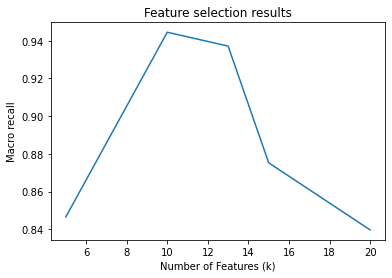

In [160]:
recalls = []
ks = [5, 10, 13, 15, 20]

x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train)
y_train_one_hot = keras.utils.to_categorical(y_train)
y_val_one_hot = keras.utils.to_categorical(y_val)

for k in ks:
   
    # configure to select k features
    fs = SelectKBest(score_func=chi2, k=k)

    # learn relationship from training data
    fs.fit(x_train, y_train)

    # transform train input data
    X_train_fs = fs.transform(x_train)

    # transform test input data
    X_val_fs = fs.transform(x_val)

    print("k = %d, selected_features: %s"% (k, str(fs.get_feature_names_out())))
    model = KerasClassifier(build_fn=create_model, input_shape=X_train_fs.shape[1], epochs=200, verbose=0, hidden_layer_sizes=(256,256,256,))
    model.fit(X_train_fs,y_train_one_hot)

    y_pred = model.predict(X_val_fs)

    recall_value = recall_score(y_val,y_pred, average="macro")
    print(confusion_matrix(y_val, y_pred))
    recalls.append(recall_value)


best_k = ks[np.argmax(recalls)]

plt.title("Feature selection results")
plt.xlabel("Number of Features (k)")
plt.ylabel("Macro recall")
plt.plot(ks, recalls)
plt.show()

## Testing hyperparameters

In this section, we test whether we can improve the performance by changing the hyperparameters.

### Learning rate

In the following code, we test some lr values.
One can see that $0.001$ was slightly better than most other lrs.

========== lr=0.000100 ==========
Confusion Matrix

[[  61   11    1]
 [   1  149   27]
 [   9   22 3147]]

Classification Report

              precision    recall  f1-score   support

     Class 1       0.86      0.84      0.85        73
     Class 2       0.82      0.84      0.83       177
     Class 3       0.99      0.99      0.99      3178

    accuracy                           0.98      3428
   macro avg       0.89      0.89      0.89      3428
weighted avg       0.98      0.98      0.98      3428

========== lr=0.001000 ==========
Confusion Matrix

[[  67    2    4]
 [   1  166   10]
 [  23   23 3132]]

Classification Report

              precision    recall  f1-score   support

     Class 1       0.74      0.92      0.82        73
     Class 2       0.87      0.94      0.90       177
     Class 3       1.00      0.99      0.99      3178

    accuracy                           0.98      3428
   macro avg       0.87      0.95      0.90      3428
weighted avg       0.98      0.

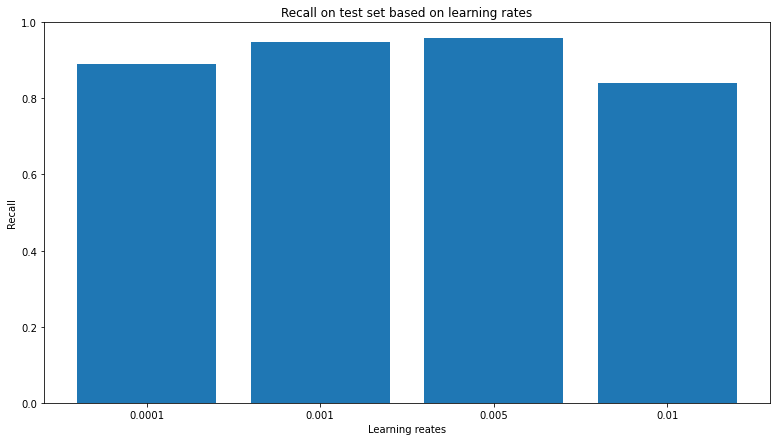

In [161]:
lrs = [1e-4,1e-3,  5e-3, 1e-2]

# configure to select k features
fs = SelectKBest(score_func=chi2, k=best_k)

# learn relationship from training data
fs.fit(x_train, y_train)

# transform train input data
X_train_fs = fs.transform(x_train)

# transform test input data
X_val_fs = fs.transform(x_val)

# transform test input data
X_test_fs = fs.transform(X_test)

recalls = []
histories = []
for lr in lrs:
    print("="*10, "lr=%f" % lr, "="*10)
    
    # Using the wrapper for Keras Classifier
    model =KerasClassifier(create_model, 
        lr=lr, 
        verbose=0, 
        epochs=200, 
        validation_data=(X_val_fs, y_val_one_hot), 
        input_shape=X_train_fs.shape[1]
        )

    # Fitting the model and saving the history.
    history = model.fit(X_train_fs, y_train_one_hot)
    histories.append(history)

    # Making predictions
    y_pred = model.predict(X_test_fs)
    evaluate(y_test, y_pred, "Validation")
    recalls.append(recall_score(y_test, y_pred, average="macro"))

# Plotting recalls for learning rates

plt.figure(figsize=(13,7))
plt.xlabel("Learning reates")
plt.ylabel("Recall")
plt.title("Recall on test set based on learning rates")

plt.bar([str(x) for x in lrs],recalls)

plt.ylim([0,1])
plt.show()

In the following, we plot the loss for the best learning rate.

One can see that the validation and training losses are starting to diverge in the last epochs.

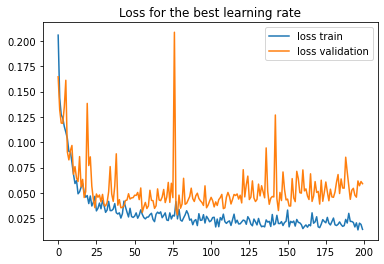

In [162]:
# Plotting loss curve for best learning rate.

history = histories[np.argmax(recalls)]
plt.title("Loss for the best learning rate")
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss validation')
plt.legend()